In [9]:
%load_ext autoreload
%autoreload 2

In [10]:
import json

model_key = "meta-llama/Llama-3.3-70B-Instruct"

with open(f"figures/{model_key.split('/')[-1]}/raw/aie_per_head.json", "r") as f:
    aie_per_head = json.load(f)

aie_per_head = {(layer_idx, head_idx): aie for layer_idx, head_idx, aie in aie_per_head} 

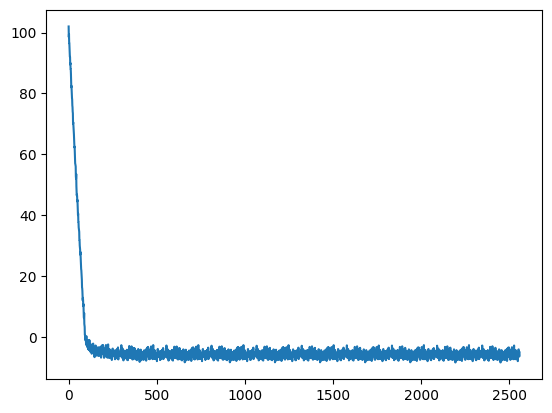

79


(True, True)

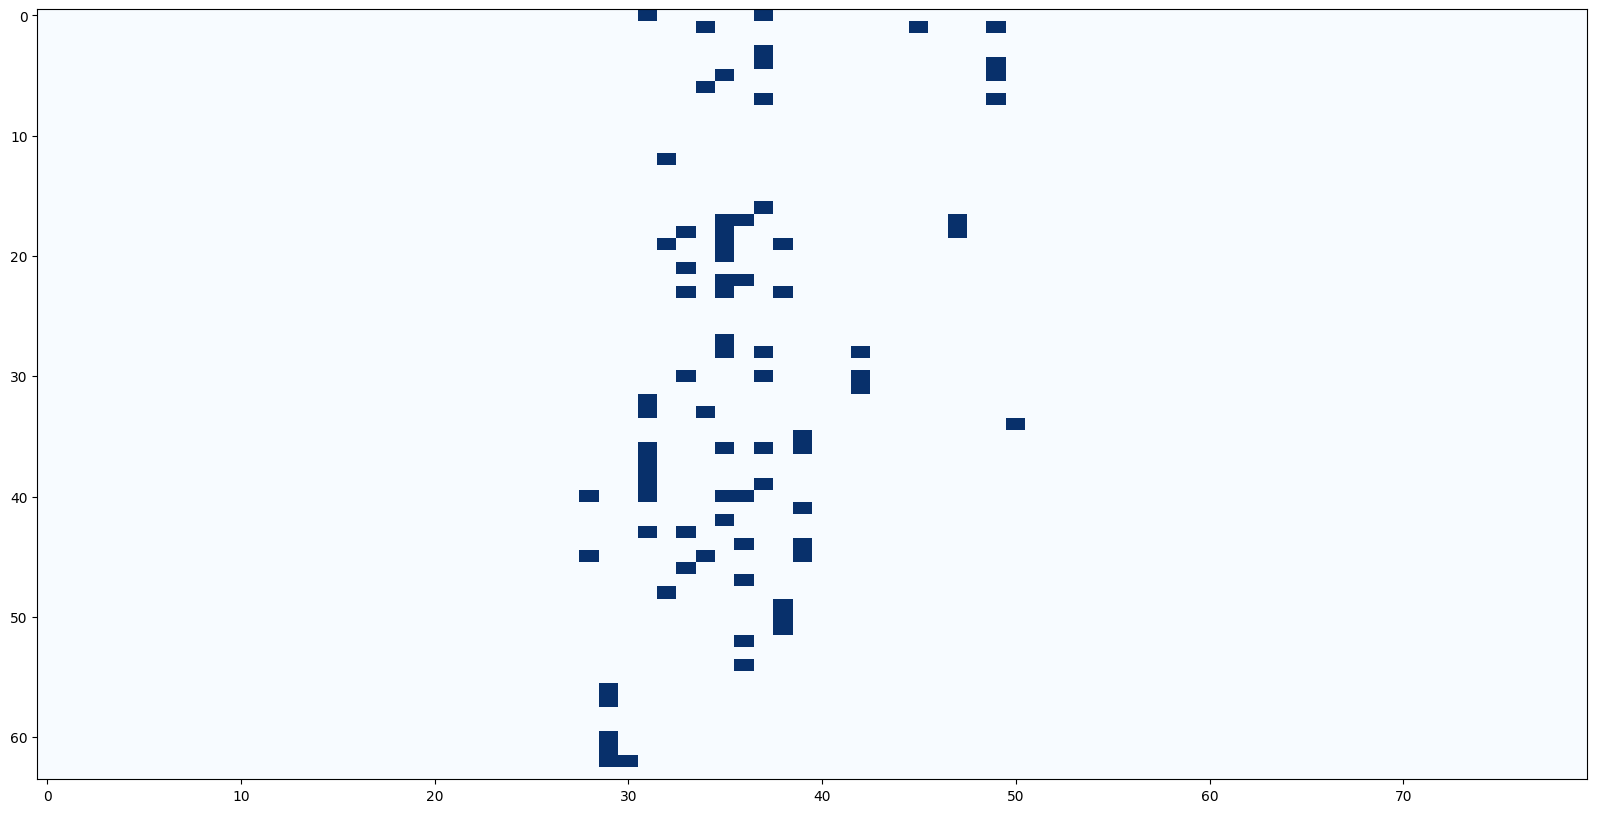

In [11]:
import sys

sys.path.append("../")

from matplotlib import pyplot as plt
import numpy as np
from src.utils import env_utils
import os
import torch
plt.rcdefaults()

optimized_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection/optimized_heads",
    model_key.split("/")[-1],
    "distinct_options",
    # f"{select_task.task_name}",
    "select_one",
    # "legacy",
    "epoch_10.npz"
)

optimization_results = np.load(optimized_path, allow_pickle=True)
plt.plot(optimization_results["losses"])
plt.show()

plt.figure(figsize=(20, 10))

optimal_head_mask = torch.tensor(optimization_results["optimal_mask"]).to(torch.float32)
optimal_head_mask[52:, :] = 0.0

plt.imshow(
    optimal_head_mask.T.numpy(),
    cmap="Blues",
    aspect="auto",
    vmin=0,
    vmax=1,
)

optimized_heads = torch.nonzero(optimal_head_mask > 0.5, as_tuple=False).tolist()
optimized_heads = [
    (layer_idx, head_idx) for layer_idx, head_idx in optimized_heads
]
print(len(optimized_heads))

HEADS = optimized_heads

(35, 19) in HEADS, (35, 19) in optimized_heads
# [(29, 3) in HEADS]

In [12]:
len(optimized_heads)

79

28 40
28 45
29 56
29 57
29 60
29 61
29 62
30 62
31 0
31 32
31 33
31 36
31 37
31 38
31 39
31 40
31 43
32 12
32 19
32 48
33 18
33 21
33 23
33 30
33 43
33 46
34 1
34 6
34 33
34 45
35 5
35 17
35 18
35 19
35 20
35 22
35 23
35 27
35 28
35 36
35 40
35 42
36 17
36 22
36 40
36 44
36 47
36 52
36 54
37 0
37 3
37 4
37 7
37 16
37 28
37 30
37 36
37 39
38 19
38 23
38 49
38 50
38 51
39 35
39 36
39 41
39 44
39 45
42 28
42 30
42 31
45 1
47 17
47 18
49 1
49 4
49 5
49 7
50 34


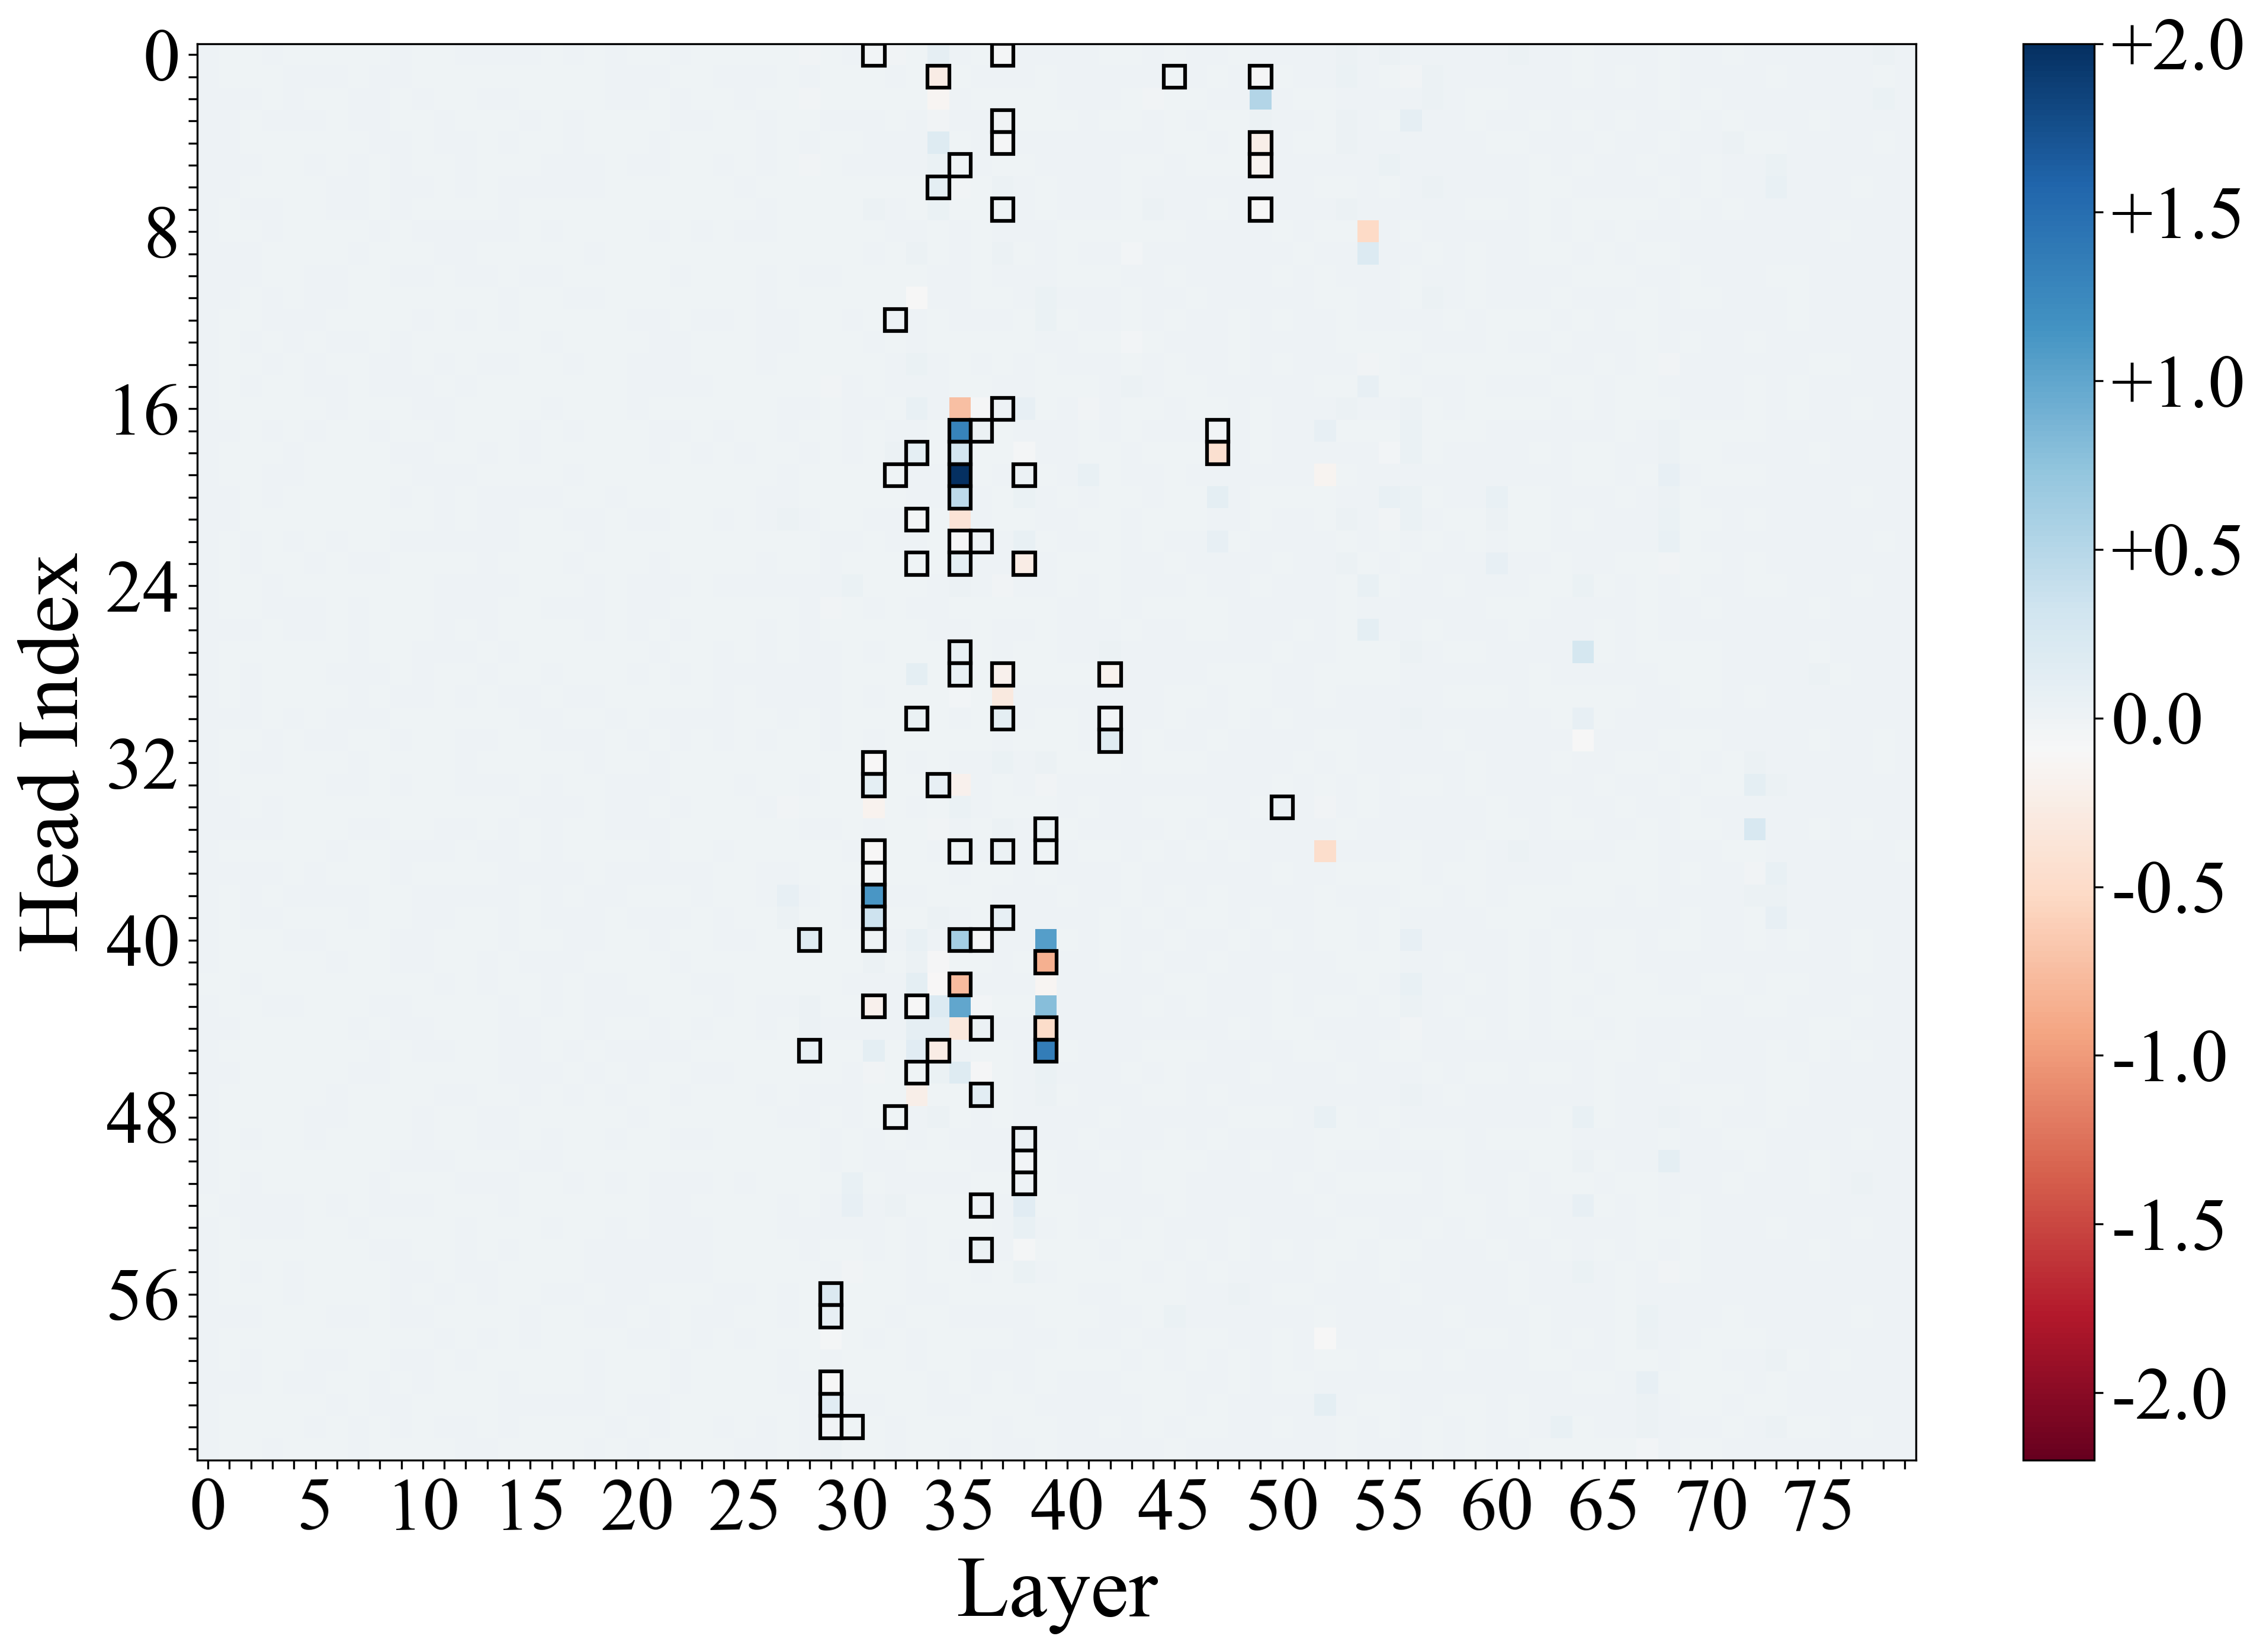

In [17]:
from matplotlib import category, pyplot as plt
import os
from matplotlib.ticker import FuncFormatter

import json
import matplotlib.patches as patches
import torch

plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.family"] = "Times New Roman"

SMALL_SIZE = 50
MEDIUM_SIZE = 55
BIGGER_SIZE = 60

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title



plt.rcParams["figure.dpi"] = 300
plt.rcParams["font.family"] = "Times New Roman"

SMALL_SIZE = 30
MEDIUM_SIZE = 35
BIGGER_SIZE = 40

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig_save_path = os.path.join("figures", model_key.split("/")[-1], "aie")
os.makedirs(fig_save_path, exist_ok=True)

n_layer = 80
n_heads = 64

category_wise_heads = {}
indirect_effects = torch.zeros((n_layer, n_heads), dtype=torch.float32)
for layer_idx in range(n_layer):
    for head_idx in range(n_heads):
        indirect_effects[layer_idx, head_idx] = aie_per_head[(layer_idx, head_idx)]

plt.figure(figsize=(14, 10))
scale = torch.max(torch.abs(indirect_effects))
plt.imshow(
    indirect_effects.T.cpu().numpy(),
    cmap="RdBu",
    aspect="auto",
    # vmin=-scale,
    # vmax=scale,
    # vmin=-0.15,
    # vmax=0.15,
    vmin=2,
    vmax=-2
)
cbar = plt.colorbar()
# Format colorbar tick labels to show + sign for positive values
cbar.ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: f"{x:+.1f}" if x != 0 else "0.0"))
# plt.title(f"score(target) - max(score(distractors)) | {token_idx.upper()} tokens of options")
# plt.title("IE of q_proj patching | " + category)
plt.xlabel("Layer")
plt.ylabel("Head Index")

def get_ticks(ticks, skip=5):
    ret = []
    for i in ticks:
        if i % skip == 0:
            ret.append(str(i))
        else:
            ret.append("")
    return ret

plt.xticks(
    ticks=range(n_layer),
    labels=get_ticks(range(n_layer)),
    rotation=1,
)
plt.yticks(
    ticks=range(n_heads),
    labels=get_ticks(range(n_heads), skip=8),
)

# Get the current axes
ax = plt.gca()

# Draw borders around marked cells
for (x, y) in optimized_heads:
    print(x, y)
    # Create a Rectangle patch
    # Note: (x-0.5, y-0.5) positions the rectangle correctly around the cell
    # Width and height of 1 covers exactly one cell
    rect = patches.Rectangle(
        (x - 0.5, y - 0.5),  # bottom-left corner
        1,                     # width
        1,                     # height
        linewidth=1.5,          # border thickness
        edgecolor='black',    # border color (you can change this)
        facecolor='none'      # no fill, just border
    )
    ax.add_patch(rect)  # FIXED: This should be inside the loop!

plt.tight_layout()
plt.savefig(os.path.join(fig_save_path, "objects.pdf"), bbox_inches='tight', pad_inches=0)
plt.show()

28 40
28 45
29 56
29 57
29 60
29 61
29 62
30 62
31 0
31 32
31 33
31 36
31 37
31 38
31 39
31 40
31 43
32 12
32 19
32 48
33 18
33 21
33 23
33 30
33 43
33 46
34 1
34 6
34 33
34 45
35 5
35 17
35 18
35 19
35 20
35 22
35 23
35 27
35 28
35 36
35 40
35 42
36 17
36 22
36 40
36 44
36 47
36 52
36 54
37 0
37 3
37 4
37 7
37 16
37 28
37 30
37 36
37 39
38 19
38 23
38 49
38 50
38 51
39 35
39 36
39 41
39 44
39 45
42 28
42 30
42 31
45 1
47 17
47 18
49 1
49 4
49 5
49 7
50 34


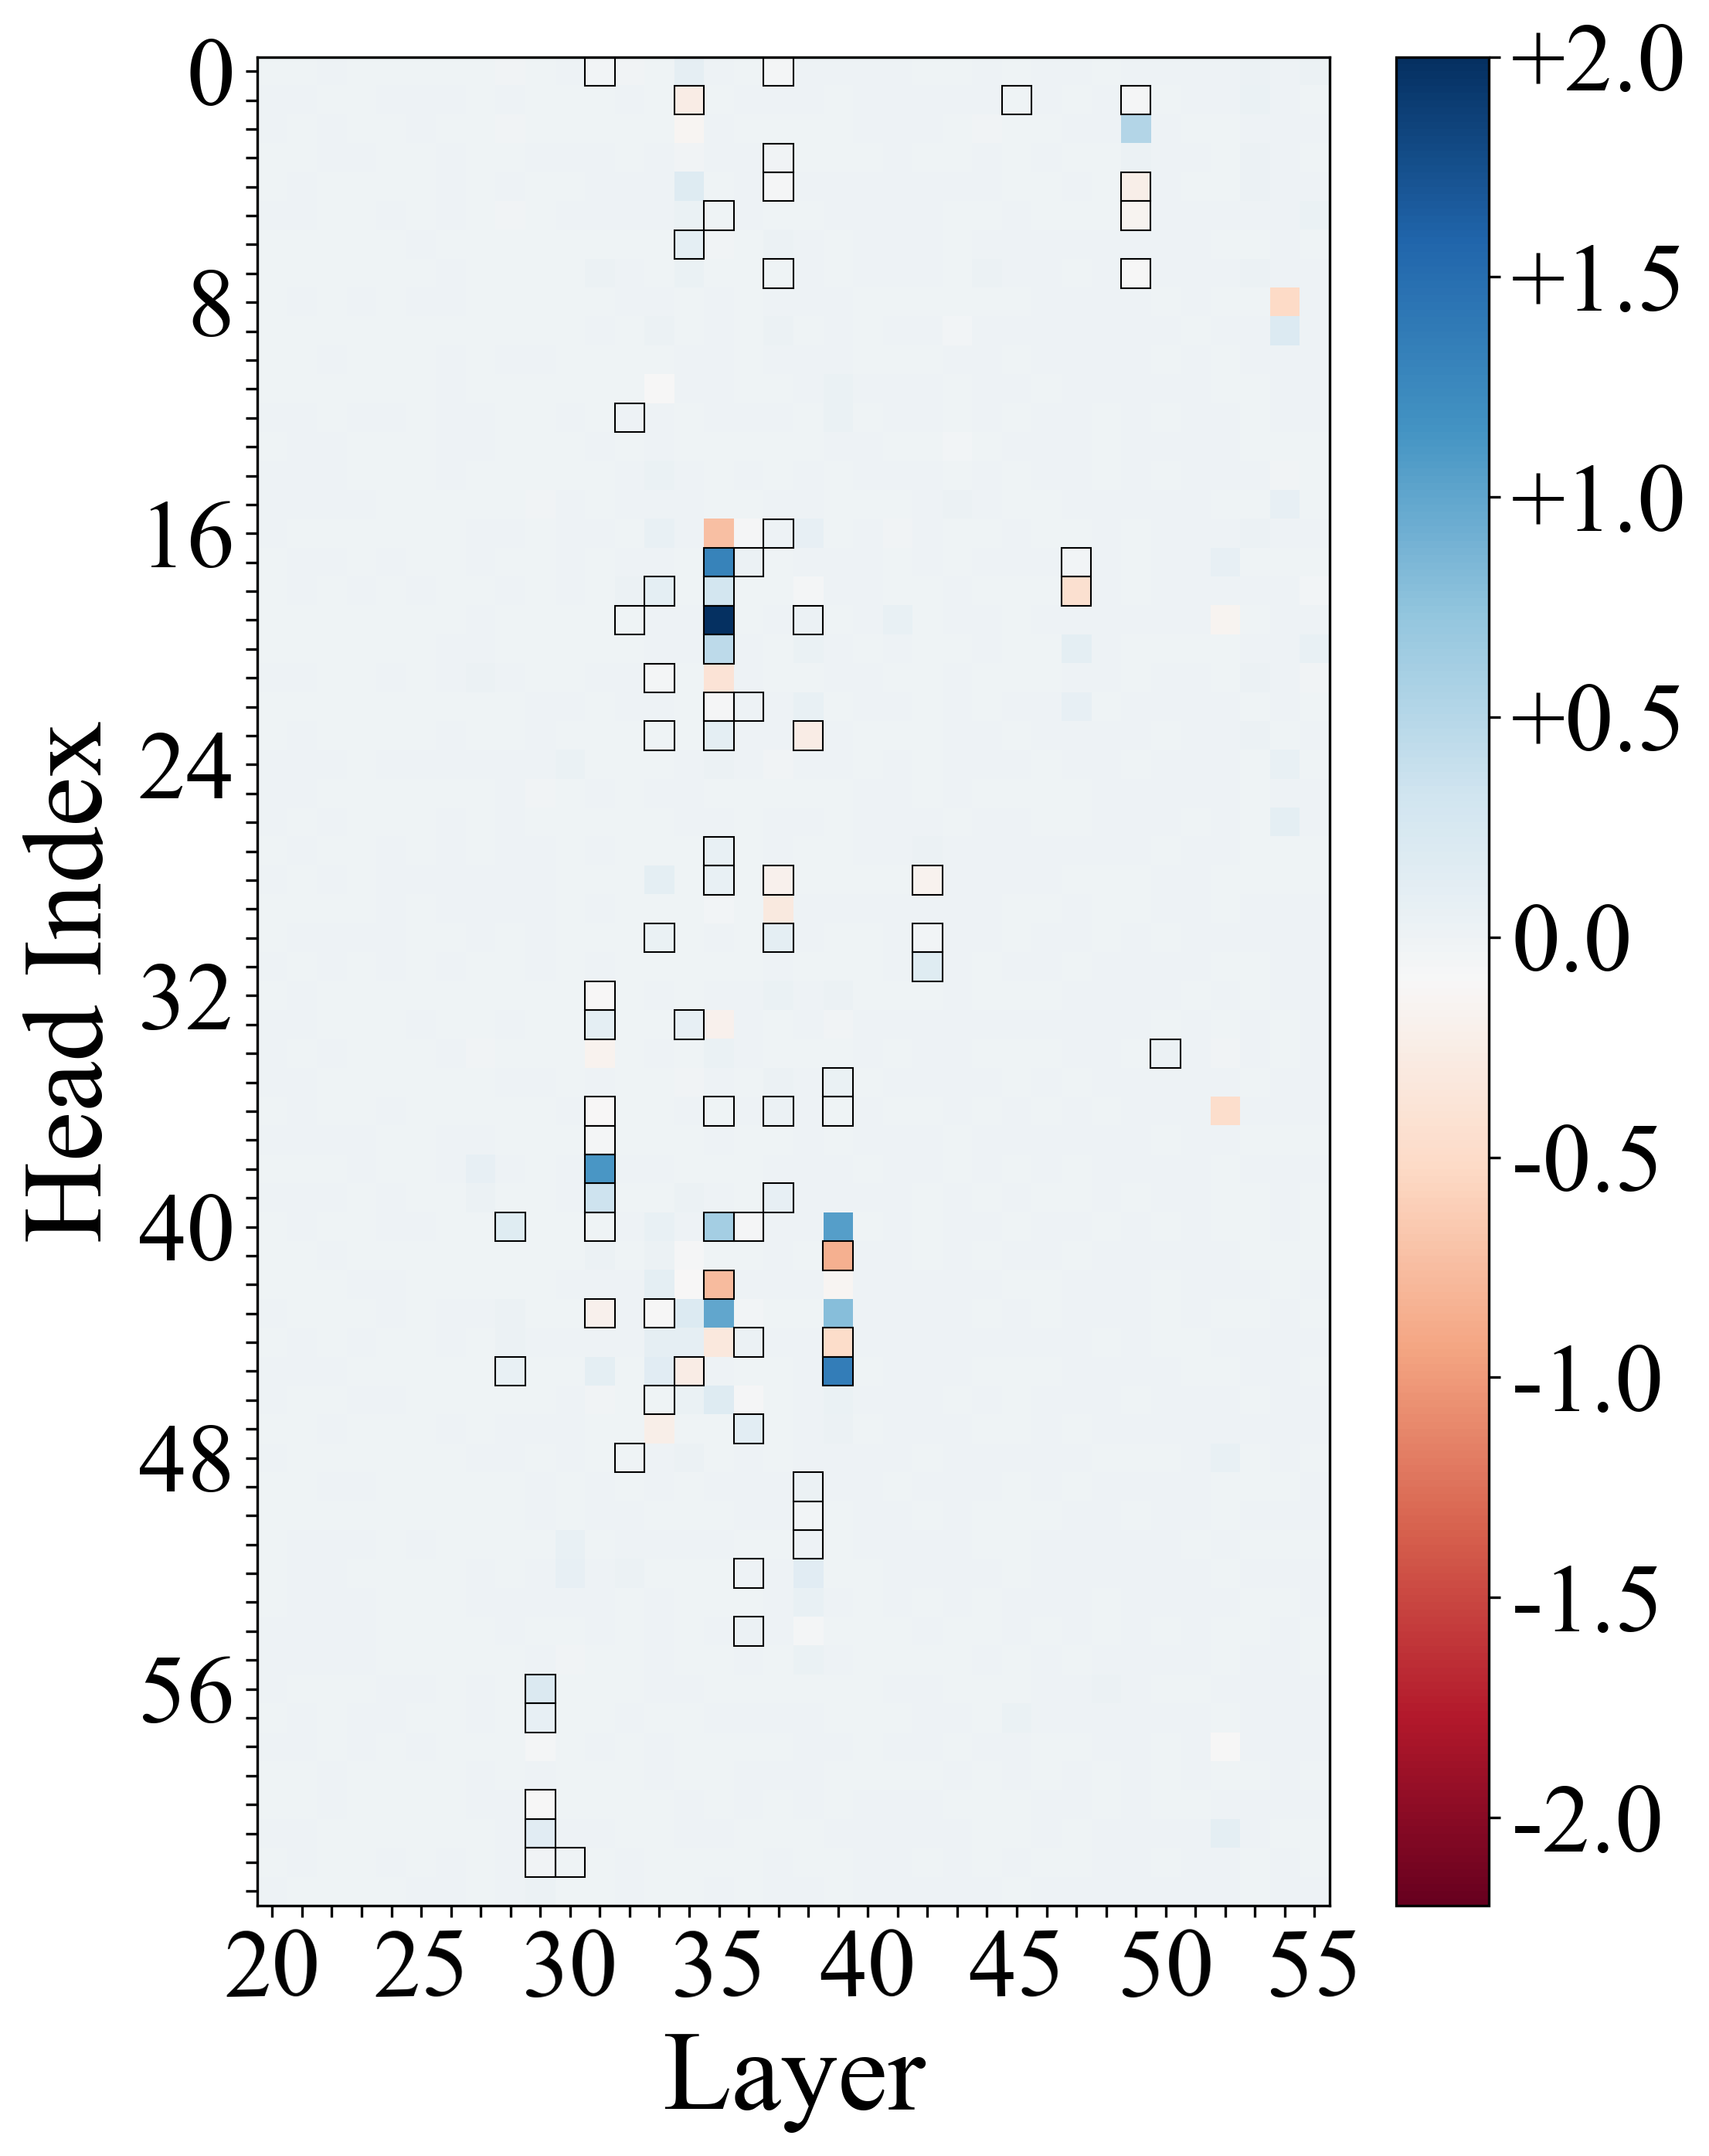

In [22]:
from matplotlib import category, pyplot as plt
import os
from matplotlib.ticker import FuncFormatter

import json
import matplotlib.patches as patches
import torch

plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.family"] = "Times New Roman"

SMALL_SIZE = 50
MEDIUM_SIZE = 55
BIGGER_SIZE = 60

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title



plt.rcParams["figure.dpi"] = 300
plt.rcParams["font.family"] = "Times New Roman"

SMALL_SIZE = 30
MEDIUM_SIZE = 35
BIGGER_SIZE = 40

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig_save_path = os.path.join("figures", model_key.split("/")[-1], "aie")
os.makedirs(fig_save_path, exist_ok=True)

n_layer = 80
n_heads = 64

# Define the layer range to display
layer_start = 20
layer_end = 55  # inclusive

category_wise_heads = {}
indirect_effects = torch.zeros((n_layer, n_heads), dtype=torch.float32)
for layer_idx in range(n_layer):
    for head_idx in range(n_heads):
        indirect_effects[layer_idx, head_idx] = aie_per_head[(layer_idx, head_idx)]

# Slice the data to only show layers 20-60
indirect_effects_subset = indirect_effects[layer_start:layer_end+1, :]

plt.figure(figsize=(8, 10))
scale = torch.max(torch.abs(indirect_effects_subset))
plt.imshow(
    indirect_effects_subset.T.cpu().numpy(),
    cmap="RdBu",
    aspect="auto",
    # vmin=-scale,
    # vmax=scale,
    # vmin=-0.15,
    # vmax=0.15,
    vmin=2,
    vmax=-2
)
cbar = plt.colorbar()
# Format colorbar tick labels to show + sign for positive values
cbar.ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: f"{x:+.1f}" if x != 0 else "0.0"))
# plt.title(f"score(target) - max(score(distractors)) | {token_idx.upper()} tokens of options")
# plt.title("IE of q_proj patching | " + category)
plt.xlabel("Layer")
plt.ylabel("Head Index")

def get_ticks(ticks, skip=5, offset=0):
    ret = []
    for i in ticks:
        actual_layer = i + offset
        if actual_layer % skip == 0:
            ret.append(str(actual_layer))
        else:
            ret.append("")
    return ret

# Set x-ticks for the subset of layers
n_layers_shown = layer_end - layer_start + 1
plt.xticks(
    ticks=range(n_layers_shown),
    labels=get_ticks(range(n_layers_shown), skip=5, offset=layer_start),
    rotation=1,
)
plt.yticks(
    ticks=range(n_heads),
    labels=get_ticks(range(n_heads), skip=8),
)

# Get the current axes
ax = plt.gca()

# Draw borders around marked cells
# Note: Need to adjust x-coordinates for the subset
for (x, y) in optimized_heads:
    # Only draw if the head is within the displayed layer range
    if layer_start <= x <= layer_end:
        print(x, y)
        # Adjust x-coordinate to match the new indexing
        adjusted_x = x - layer_start
        # Create a Rectangle patch
        # Note: (adjusted_x-0.5, y-0.5) positions the rectangle correctly around the cell
        # Width and height of 1 covers exactly one cell
        rect = patches.Rectangle(
            (adjusted_x - 0.5, y - 0.5),  # bottom-left corner
            1,                     # width
            1,                     # height
            linewidth=0.5,          # border thickness
            edgecolor='black',    # border color (you can change this)
            facecolor='none'      # no fill, just border
        )
        ax.add_patch(rect)  # FIXED: This should be inside the loop!

plt.tight_layout()
plt.savefig(os.path.join(fig_save_path, "objects-sliced.pdf"), bbox_inches='tight', pad_inches=0)
plt.show()

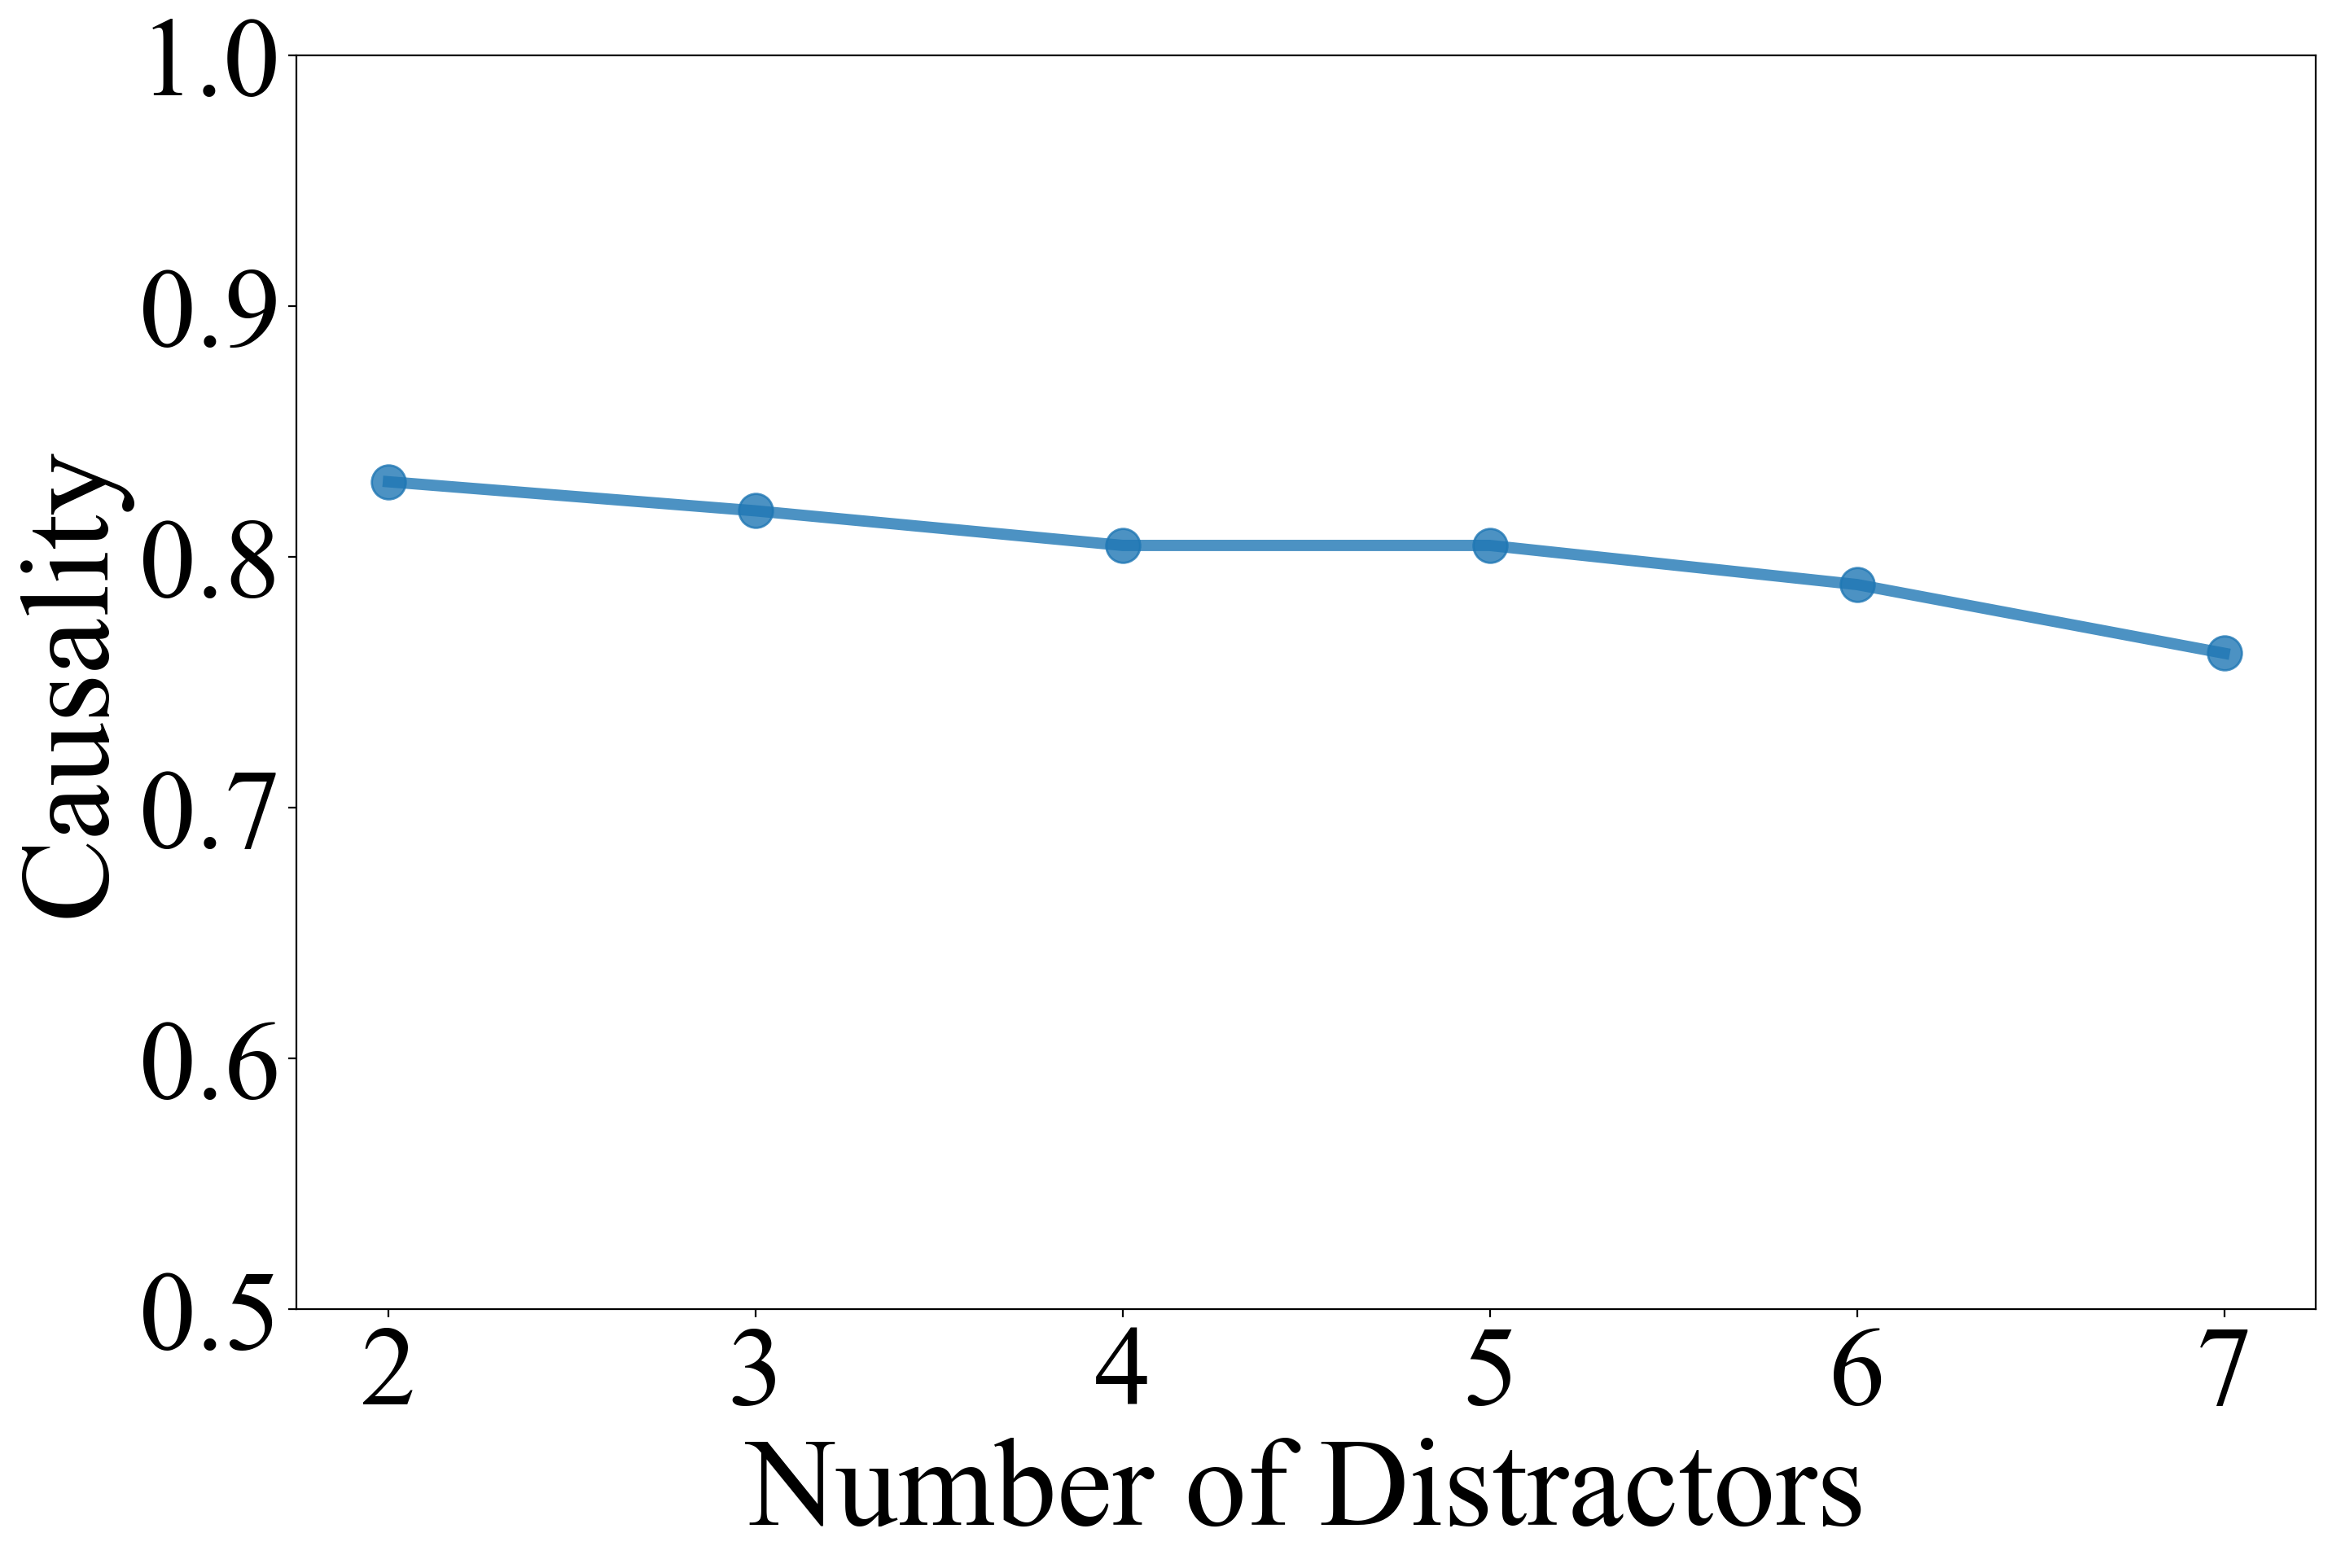

In [7]:
from matplotlib import pyplot as plt
import os
plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.family"] = "Times New Roman"

SMALL_SIZE = 50
MEDIUM_SIZE = 55
BIGGER_SIZE = 60

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title


n_dist_performance = {
    2: (0.8301, 7.5886),
    3: (0.8185, 7.9886),
    4: (0.8047, 8.4584),
    5: (0.8047, 8.6950),
    6: (0.7891, 8.4796),
    7: (0.7617, 8.6022),
}


plt.rc("figure", figsize=(16, 10))
plt.plot(
    list(n_dist_performance.keys()),
    [x[0] for x in n_dist_performance.values()],
    marker="o",
    linewidth=5,
    markersize=15,
    alpha=0.8,
)
plt.xlabel("Number of Distractors")
plt.ylabel("Causality")
plt.ylim(0.5, 1)
plt.xticks(list(n_dist_performance.keys()))

save_path = os.path.join("figures")
os.makedirs(save_path, exist_ok=True)
plt.savefig(os.path.join(save_path, "causality_vs_n_distractors.pdf"), bbox_inches="tight")

In [3]:
#! Only checked the causality values. Some of the values are off

train_vs_evaluation = {
    "Select One": {
        "num_heads": 79,
        "evaluation": {
            "Select One": {
                "causality": 0.8633,
                "n_correct": 884,
                "out_of": 1024,
                "delta_logit": 9.0276
            },
            "Select First": {
                "causality": 0.6875,
                "n_correct": 352,
                "out_of": 512,
                "delta_logit": 5.1055
            },
            "Select Last": {
                "causality": 0.7769,
                "n_correct": 395,
                "out_of": 512,
                "delta_logit": 8.0176
            },
            "Select One - MCQ": {
                "causality": 0.8418,
                "n_correct": 374,
                "out_of": 512,
                "delta_logit": 5.8535
            },
            "Counting": {
                "causality": 0.0410,
                "n_correct": 21,
                "out_of": 512,
                "delta_logit": 1.2270
            },
            "Yes/No": {
                "causality": 0.0176,
                "n_correct": 9,
                "out_of": 512,
                "delta_logit": 0.4799
            }
        }
    },
    "Select First": {
        "num_heads": 81,
        "evaluation": {
            "Select One": {
                "causality": 0.7910,
                "n_correct": 405,
                "out_of": 512,
                "delta_logit": 9.5619
            },
            "Select First": {
                "causality": 0.7285,
                "n_correct": 396,
                "out_of": 512,
                "delta_logit": 7.2440
            },
            "Select Last": {
                "causality": 0.7730,
                "n_correct": 374,
                "out_of": 512,
                "delta_logit": 8.6836
            },
            "Select One - MCQ": {
                "causality": 0.6934,
                "n_correct": 355,
                "out_of": 512,
                "delta_logit": 5.2285
            },
            "Counting": {
                "causality": 0.1270,
                "n_correct": 65,
                "out_of": 512,
                "delta_logit": 1.9473
            },
            "Yes/No": {
                "causality": 0.0059,
                "n_correct": 3,
                "out_of": 512,
                "delta_logit": 0.6457
            }
        }
    },
    "Select Last": {
        "num_heads": 145,
        "evaluation": {
            "Select One": {
                "causality": 0.7617,
                "n_correct": 390,
                "out_of": 512,
                "delta_logit": 8.2188
            },
            "Select First": {
                "causality": 0.6016,
                "n_correct": 308,
                "out_of": 512,
                "delta_logit": 7.3594
            },
            "Select Last": {
                "causality": 0.8789,
                "n_correct": 840,
                "out_of": 1024,
                "delta_logit": 8.2751
            },
            "Select One - MCQ": {
                "causality": 0.7744,
                "n_correct": 790,
                "out_of": 1024,
                "delta_logit": 5.5957
            },
            "Counting": {
                "causality": 0.1387,
                "n_correct": 71,
                "out_of": 512,
                "delta_logit": 2.1542
            },
            "Yes/No": {
                "causality": 0.0352,
                "n_correct": 18,
                "out_of": 512,
                "delta_logit": 0.3779
            }
        }
    },
    "Select One - MCQ": {
        "num_heads": 45,
        "evaluation": {
            "Select One": {
                "causality": 0.5918,
                "n_correct": 303,
                "out_of": 512,
                "delta_logit": 7.0840
            },
            "Select First": {
                "causality": 0.2734,
                "n_correct": 223,
                "out_of": 512,
                "delta_logit": 2.8923
            },
            "Select Last": {
                "causality": 0.4384,
                "n_correct": 224,
                "out_of": 511,
                "delta_logit": 5.7093
            },
            "Select One - MCQ": {
                "causality": 0.9043,
                "n_correct": 450,
                "out_of": 512,
                "delta_logit": 5.0955
            },
            "Counting": {
                "causality": 0.0645,
                "n_correct": 33,
                "out_of": 512,
                "delta_logit": 1.2347
            },
            "Yes/No": {
                "causality": 0.0215,
                "n_correct": 11,
                "out_of": 512,
                "delta_logit": 0.3444
            }
        }
    },
    "Counting": {
        "num_heads": 64,
        "evaluation": {
            "Select One": {
                "causality": 0.6094,
                "n_correct": 312,
                "out_of": 512,
                "delta_logit": 6.8508
            },
            "Select First": {
                "causality": 0.3789,
                "n_correct": 194,
                "out_of": 512,
                "delta_logit": 2.8218
            },
            "Select Last": {
                "causality": 0.5832,
                "n_correct": 299,
                "out_of": 511,
                "delta_logit": 2.9157
            },
            "Select One - MCQ": {
                "causality": 0.7871,
                "n_correct": 195,
                "out_of": 512,
                "delta_logit": 1.7144
            },
            "Counting": {
                "causality": 0.3555,
                "n_correct": 177,
                "out_of": 512,
                "delta_logit": 2.3633
            },
            "Yes/No": {
                "causality": 0.0469,
                "n_correct": 9,
                "out_of": 512,
                "delta_logit": 0.4086
            }
        }
    },
    "Yes/No": {
        "num_heads": 21,
        "evaluation": {
            "Select One": {
                "causality": 0.0820,
                "n_correct": 42,
                "out_of": 512,
                "delta_logit": 4.5545
            },
            "Select First": {
                "causality": 0.0957,
                "n_correct": 49,
                "out_of": 512,
                "delta_logit": 4.3595
            },
            "Select Last": {
                "causality": 0.1487,
                "n_correct": 76,
                "out_of": 511,
                "delta_logit": 4.4409
            },
            "Select One - MCQ": {
                "causality": 0.3574,
                "n_correct": 183,
                "out_of": 512,
                "delta_logit": 2.0686
            },
            "Counting": {
                "causality": 0.0762,
                "n_correct": 39,
                "out_of": 512,
                "delta_logit": 1.5039
            },
            "Yes/No": {
                "causality": 0.0898,
                "n_correct": 9,
                "out_of": 512,
                "delta_logit": 0.1039
            }
        }
    }
}

In [6]:
# for gemma-27B

#! Only checked the causality values. Some of the values are off
train_vs_evaluation = {
    "Select One": {
        "num_heads": 77,
        "evaluation": {
            "Select One": {
                "causality": 0.824,
                "n_correct": 884,
                "out_of": 1024,
                "delta_logit": 9.0276
            },
            "Select First": {
                "causality": 0.695,
                "n_correct": 352,
                "out_of": 512,
                "delta_logit": 5.1055
            },
            "Select Last": {
                "causality": 0.670,
                "n_correct": 395,
                "out_of": 512,
                "delta_logit": 8.0176
            },
            "Select One - MCQ": {
                "causality": 0.826,
                "n_correct": 374,
                "out_of": 512,
                "delta_logit": 5.8535
            },
            "Counting": {
                "causality": 0.074,
                "n_correct": 21,
                "out_of": 512,
                "delta_logit": 1.2270
            },
            "CheckPresence": {
                "causality": 0.0312,
                "n_correct": 9,
                "out_of": 512,
                "delta_logit": 0.4799
            }
        }
    },
    "Select First": {
        "num_heads": 77,
        "evaluation": {
            "Select One": {
                "causality": 0.7969,
                "n_correct": 405,
                "out_of": 512,
                "delta_logit": 9.5619
            },
            "Select First": {
                "causality": 0.6777,
                "n_correct": 396,
                "out_of": 512,
                "delta_logit": 7.2440
            },
            "Select Last": {
                "causality": 0.6855,
                "n_correct": 374,
                "out_of": 512,
                "delta_logit": 8.6836
            },
            "Select One - MCQ": {
                "causality": 0.8301,
                "n_correct": 355,
                "out_of": 512,
                "delta_logit": 5.2285
            },
            "Counting": {
                "causality": 0.0527,
                "n_correct": 65,
                "out_of": 512,
                "delta_logit": 1.9473
            },
            "CheckPresence": {
                "causality": 0.0254,
                "n_correct": 3,
                "out_of": 512,
                "delta_logit": 0.6457
            }
        }
    },
    "Select Last": {
        "num_heads": 76,
        "evaluation": {
            "Select One": {
                "causality": 0.8184,
                "n_correct": 390,
                "out_of": 512,
                "delta_logit": 8.2188
            },
            "Select First": {
                "causality": 0.6621,
                "n_correct": 308,
                "out_of": 512,
                "delta_logit": 7.3594
            },
            "Select Last": {
                "causality": 0.8809,
                "n_correct": 840,
                "out_of": 1024,
                "delta_logit": 8.2751
            },
            "Select One - MCQ": {
                "causality": 0.8184,
                "n_correct": 790,
                "out_of": 1024,
                "delta_logit": 5.5957
            },
            "Counting": {
                "causality": 0.0449,
                "n_correct": 71,
                "out_of": 512,
                "delta_logit": 2.1542
            },
            "CheckPresence": {
                "causality": 0.0215,
                "n_correct": 18,
                "out_of": 512,
                "delta_logit": 0.3779
            }
        }
    },
    "Select One - MCQ": {
        "num_heads": 39,
        "evaluation": {
            "Select One": {
                "causality": 0.4258,
                "n_correct": 303,
                "out_of": 512,
                "delta_logit": 7.0840
            },
            "Select First": {
                "causality": 0.3418,
                "n_correct": 223,
                "out_of": 512,
                "delta_logit": 2.8923
            },
            "Select Last": {
                "causality": 0.3457,
                "n_correct": 224,
                "out_of": 511,
                "delta_logit": 5.7093
            },
            "Select One - MCQ": {
                "causality": 0.8164,
                "n_correct": 450,
                "out_of": 512,
                "delta_logit": 5.0955
            },
            "Counting": {
                "causality": 0.0430,
                "n_correct": 33,
                "out_of": 512,
                "delta_logit": 1.2347
            },
            "CheckPresence": {
                "causality": 0.0254,
                "n_correct": 11,
                "out_of": 512,
                "delta_logit": 0.3444
            }
        }
    },
    "Counting": {
        "num_heads": 39,
        "evaluation": {
            "Select One": {
                "causality": 0.0273,
                "n_correct": 312,
                "out_of": 512,
                "delta_logit": 6.8508
            },
            "Select First": {
                "causality": 0.0039,
                "n_correct": 194,
                "out_of": 512,
                "delta_logit": 2.8218
            },
            "Select Last": {
                "causality": 0.0039,
                "n_correct": 299,
                "out_of": 511,
                "delta_logit": 2.9157
            },
            "Select One - MCQ": {
                "causality": 0.6074,
                "n_correct": 195,
                "out_of": 512,
                "delta_logit": 1.7144
            },
            "Counting": {
                "causality": 0.0820,
                "n_correct": 177,
                "out_of": 512,
                "delta_logit": 2.3633
            },
            "CheckPresence": {
                "causality": 0.0332,
                "n_correct": 9,
                "out_of": 512,
                "delta_logit": 0.4086
            }
        }
    },
    "CheckPresence": {
        "num_heads": 25,
        "evaluation": {
            "Select One": {
                "causality": 0.0430,
                "n_correct": 42,
                "out_of": 512,
                "delta_logit": 4.5545
            },
            "Select First": {
                "causality": 0.0098,
                "n_correct": 49,
                "out_of": 512,
                "delta_logit": 4.3595
            },
            "Select Last": {
                "causality": 0.0117,
                "n_correct": 76,
                "out_of": 511,
                "delta_logit": 4.4409
            },
            "Select One - MCQ": {
                "causality": 0.7129,
                "n_correct": 183,
                "out_of": 512,
                "delta_logit": 2.0686
            },
            "Counting": {
                "causality": 0.0529,
                "n_correct": 39,
                "out_of": 512,
                "delta_logit": 1.5039
            },
            "CheckPresence": {
                "causality": 0.0508,
                "n_correct": 9,
                "out_of": 512,
                "delta_logit": 0.1039
            }
        }
    }
}

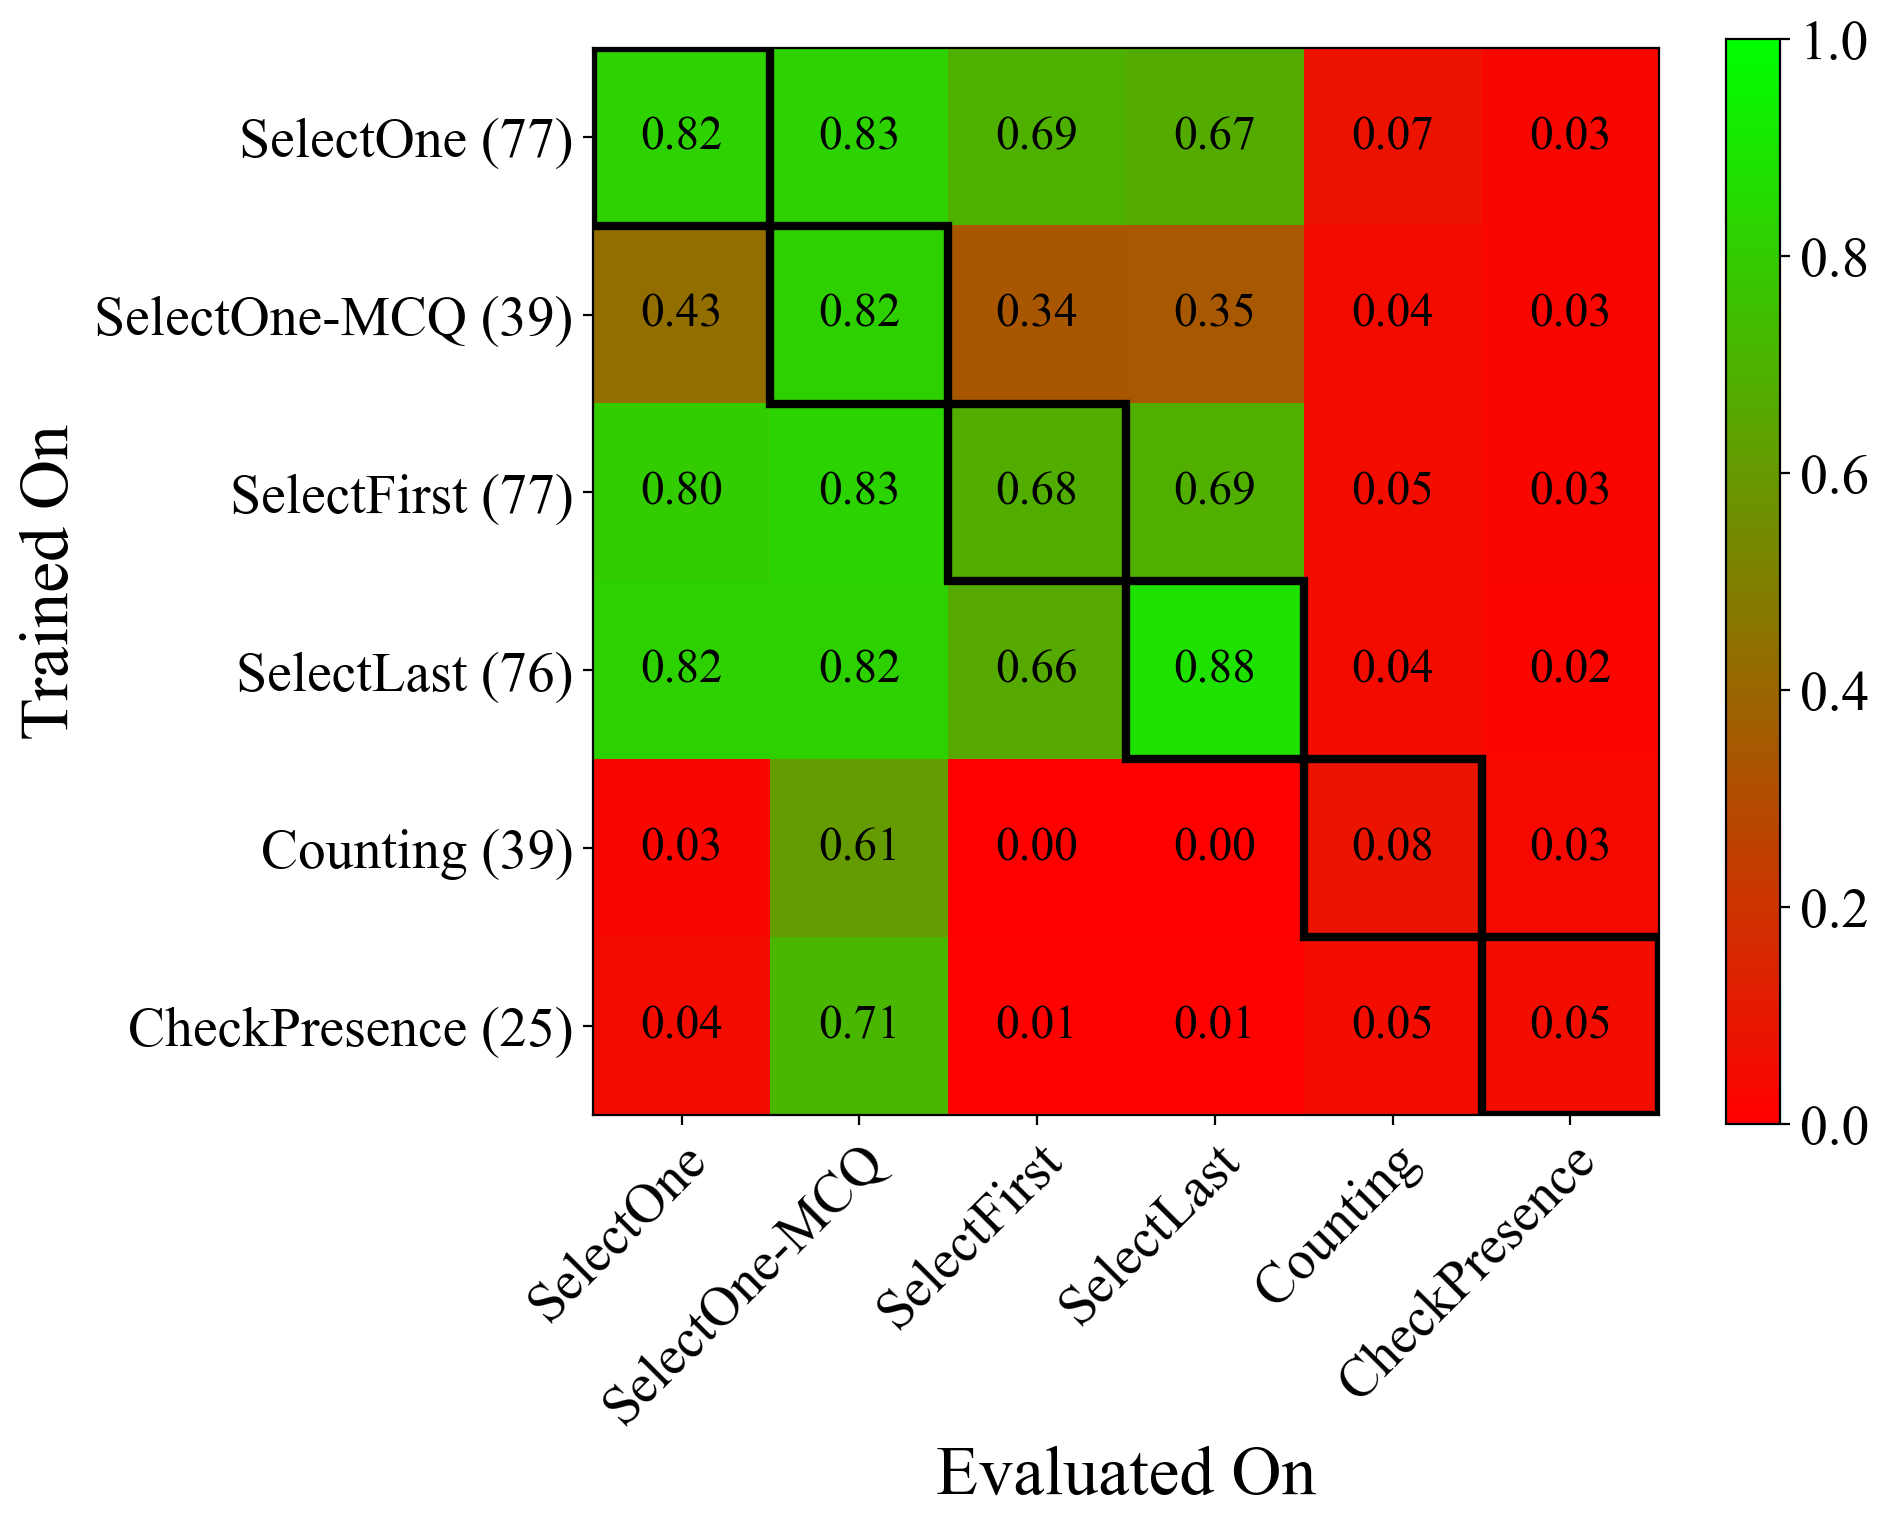

In [8]:
from matplotlib import pyplot as plt
import os
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Rectangle

plt.rcdefaults()
plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.family"] = "Times New Roman"

SMALL_SIZE = 17
MEDIUM_SIZE = 20
BIGGER_SIZE = 25

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=BIGGER_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title


# Extract labels for the axes
labels = [
    "Select One",
    "Select One - MCQ",
    "Select First",
    "Select Last",
    "Counting",
    # "Yes/No"
    "CheckPresence"
]
num_labels = len(labels)

# Create a 2D numpy array to hold the causality values
causality_matrix = np.zeros((num_labels, num_labels))

# for i, (trained_on, trained_data) in enumerate(train_vs_evaluation.items()):
#     for j, (evaluated_on, eval_data) in enumerate(trained_data["evaluation"].items()):
#         # Ensure the order of evaluation labels matches the primary labels list
#         if evaluated_on in labels:
#             j_idx = labels.index(evaluated_on)
#             causality_matrix[i, j_idx] = eval_data["causality"]
for i, trained_on in enumerate(labels):
    num_heads = train_vs_evaluation[trained_on]["num_heads"]
    eval_data = train_vs_evaluation[trained_on]["evaluation"]
    for j, evaluated_on in enumerate(labels):
        causality_matrix[i, j] = eval_data[evaluated_on]["causality"]

# Create the plot
fig, ax = plt.subplots(figsize=(10, 8))
colors = [(1, 0, 0), (0, 1, 0)] # Red -> Green
# colors = ["#ff0000", "#4D7300"]
custom_cmap = LinearSegmentedColormap.from_list('green_to_red_cmap', colors, N=256)
im = ax.imshow(causality_matrix, cmap=custom_cmap, vmin=0, vmax=1)

# Set ticks and labels
ax.set_xticks(np.arange(num_labels))
ax.set_yticks(np.arange(num_labels))
ax.set_xticklabels([label.replace(" ", "") for label in labels])
ax.set_yticklabels([f'{label.replace(" ", "")} ({train_vs_evaluation[label]["num_heads"]})' for label in labels])

# Rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations
for i in range(num_labels):
    for j in range(num_labels):
        # Use a contrasting color for the text
        # text_color = "w" if causality_matrix[i, j] < 0.5 else "k"
        text_color = 'k'
        text = ax.text(j, i, f"{causality_matrix[i, j]:.2f}",
                       ha="center", va="center", color=text_color)

# Add black borders around diagonal cells (where i == j)
for i in range(num_labels):
    rect = Rectangle((i - 0.5, i - 0.5), 1, 1, 
                     linewidth=3, edgecolor='black', facecolor='none')
    ax.add_patch(rect)

# Add a colorbar
cbar = fig.colorbar(im)
# cbar.set_label("Causality Value", rotation=-90, va="bottom")


ax.set_xlabel("Evaluated On")
ax.set_ylabel("Trained On")
# ax.set_title("Causality Confusion Matrix")

# Adjust layout to prevent labels from being cut off
fig.tight_layout()

# Save the figure
save_path = os.path.join("figures")
os.makedirs(save_path, exist_ok=True)
plt.savefig(os.path.join(save_path, "gemma-head_transfer.pdf"), bbox_inches="tight")

In [5]:
cached_from_and_patched_to = {
    "Select One": {
        "evaluation": {
            "Select One": {
                "causality": 0.8633,
                "n_correct": 884,
                "out_of": 1024,
                "delta_logit": 9.0276,
                "std": 3.4362
            },
            "Select First": {
                "causality": 0.5977,
                "n_correct": 306,
                "out_of": 512,
                "delta_logit": 6.8452,
                "std": 3.1353
            },
            "Select Last": {
                "causality": 0.5781,
                "n_correct": 296,
                "out_of": 512,
                "delta_logit": 6.0331,
                "std": 2.6816
            },
            "Select One - MCQ": {
                "causality": 0.8164,
                "n_correct": 418,
                "out_of": 512,
                "delta_logit": 4.7292,
                "std": 1.8834
            },
            "Counting": {
                "causality": 0.0625,
                "n_correct": 16,
                "out_of": 256,
                "delta_logit": 1.1687,
                "std": 1.2580
            },
            "Yes/No": {
                "causality": 0.0508,
                "n_correct": 13,
                "out_of": 256,
                "delta_logit": 0.5586,
                "std": 0.9411
            }
        }
    },
    "Select First": {
        "evaluation": {
            "Select One": {
                "causality": 0.6270,
                "n_correct": 321,
                "out_of": 512,
                "delta_logit": 7.2968,
                "std": 3.8706
            },
            "Select First": {
                "causality": 0.7285,
                "n_correct": 373,
                "out_of": 512,
                "delta_logit": 7.6039,
                "std": 3.2674
            },
            "Select Last": {
                "causality": 0.2812,
                "n_correct": 144,
                "out_of": 512,
                "delta_logit": 4.8309,
                "std": 3.8327
            },
            "Select One - MCQ": {
                "causality": 0.5762,
                "n_correct": 295,
                "out_of": 512,
                "delta_logit": 3.6907,
                "std": 3.0142
            },
            "Counting": {
                "causality": 0.1367,
                "n_correct": 35,
                "out_of": 256,
                "delta_logit": 1.0845,
                "std": 2.4030
            },
            "Yes/No": {
                "causality": 0.0664,
                "n_correct": 17,
                "out_of": 256,
                "delta_logit": 0.7715,
                "std": 0.8603
            }
        }
    },
    "Select Last": {
        "evaluation": {
            "Select One": {
                "causality": 0.5977,
                "n_correct": 306,
                "out_of": 512,
                "delta_logit": 7.3607,
                "std": 4.4652
            },
            "Select First": {
                "causality": 0.1719,
                "n_correct": 88,
                "out_of": 512,
                "delta_logit": 4.4881,
                "std": 4.6115
            },
            "Select Last": {
                "causality": 0.8789,
                "n_correct": 450,
                "out_of": 512,
                "delta_logit": 8.1340,
                "std": 3.0683
            },
            "Select One - MCQ": {
                "causality": 0.6621,
                "n_correct": 339,
                "out_of": 512,
                "delta_logit": 3.9371,
                "std": 2.5485
            },
            "Counting": {
                "causality": 0.1289,
                "n_correct": 33,
                "out_of": 256,
                "delta_logit": 0.5649,
                "std": 2.4738
            },
            "Yes/No": {
                "causality": 0.1172,
                "n_correct": 30,
                "out_of": 256,
                "delta_logit": 0.6084,
                "std": 1.2738
            }
        }
    },
    "Select One - MCQ": {
        "evaluation": {
            "Select One": {
                "causality": 0.5957,
                "n_correct": 305,
                "out_of": 512,
                "delta_logit": 7.2503,
                "std": 3.1097
            },
            "Select First": {
                "causality": 0.2188,
                "n_correct": 112,
                "out_of": 512,
                "delta_logit": 5.2869,
                "std": 3.1375
            },
            "Select Last": {
                "causality": 0.4141,
                "n_correct": 212,
                "out_of": 512,
                "delta_logit": 5.5187,
                "std": 2.3622
            },
            "Select One - MCQ": {
                "causality": 0.9043,
                "n_correct": 463,
                "out_of": 512,
                "delta_logit": 5.2159,
                "std": 1.6849
            },
            "Counting": {
                "causality": 0.0430,
                "n_correct": 11,
                "out_of": 256,
                "delta_logit": 0.9060,
                "std": 1.1908
            },
            "Yes/No": {
                "causality": 0.1172,
                "n_correct": 30,
                "out_of": 256,
                "delta_logit": 0.2878,
                "std": 0.6663
            }
        }
    },
    "Counting": {
        "evaluation": {
            "Select One": {
                "causality": 0.6016,
                "n_correct": 308,
                "out_of": 512,
                "delta_logit": 6.9536,
                "std": 3.4198
            },
            "Select First": {
                "causality": 0.3379,
                "n_correct": 173,
                "out_of": 512,
                "delta_logit": 5.0867,
                "std": 3.2869
            },
            "Select Last": {
                "causality": 0.5020,
                "n_correct": 257,
                "out_of": 512,
                "delta_logit": 5.4534,
                "std": 2.8721
            },
            "Select One - MCQ": {
                "causality": 0.6582,
                "n_correct": 337,
                "out_of": 512,
                "delta_logit": 3.4985,
                "std": 2.2548
            },
            "Counting": {
                "causality": 0.3555,
                "n_correct": 91,
                "out_of": 256,
                "delta_logit": 3.2095,
                "std": 2.3713
            },
            "Yes/No": {
                "causality": 0.1211,
                "n_correct": 31,
                "out_of": 256,
                "delta_logit": 0.3105,
                "std": 0.5622
            }
        }
    },
    "Yes/No": {
        "evaluation": {
            "Select One": {
                "causality": 0.0195,
                "n_correct": 10,
                "out_of": 512,
                "delta_logit": 3.3517,
                "std": 2.0371
            },
            "Select First": {
                "causality": 0.0098,
                "n_correct": 5,
                "out_of": 512,
                "delta_logit": 3.0789,
                "std": 2.3057
            },
            "Select Last": {
                "causality": 0.0527,
                "n_correct": 27,
                "out_of": 512,
                "delta_logit": 2.9786,
                "std": 2.1673
            },
            "Select One - MCQ": {
                "causality": 0.1250,
                "n_correct": 64,
                "out_of": 512,
                "delta_logit": 0.8182,
                "std": 1.2771
            },
            "Counting": {
                "causality": 0.0469,
                "n_correct": 12,
                "out_of": 256,
                "delta_logit": 0.3564,
                "std": 1.2823
            },
            "Yes/No": {
                "causality": 0.0898,
                "n_correct": 23,
                "out_of": 256,
                "delta_logit": 0.1531,
                "std": 0.5732
            }
        }
    }
}

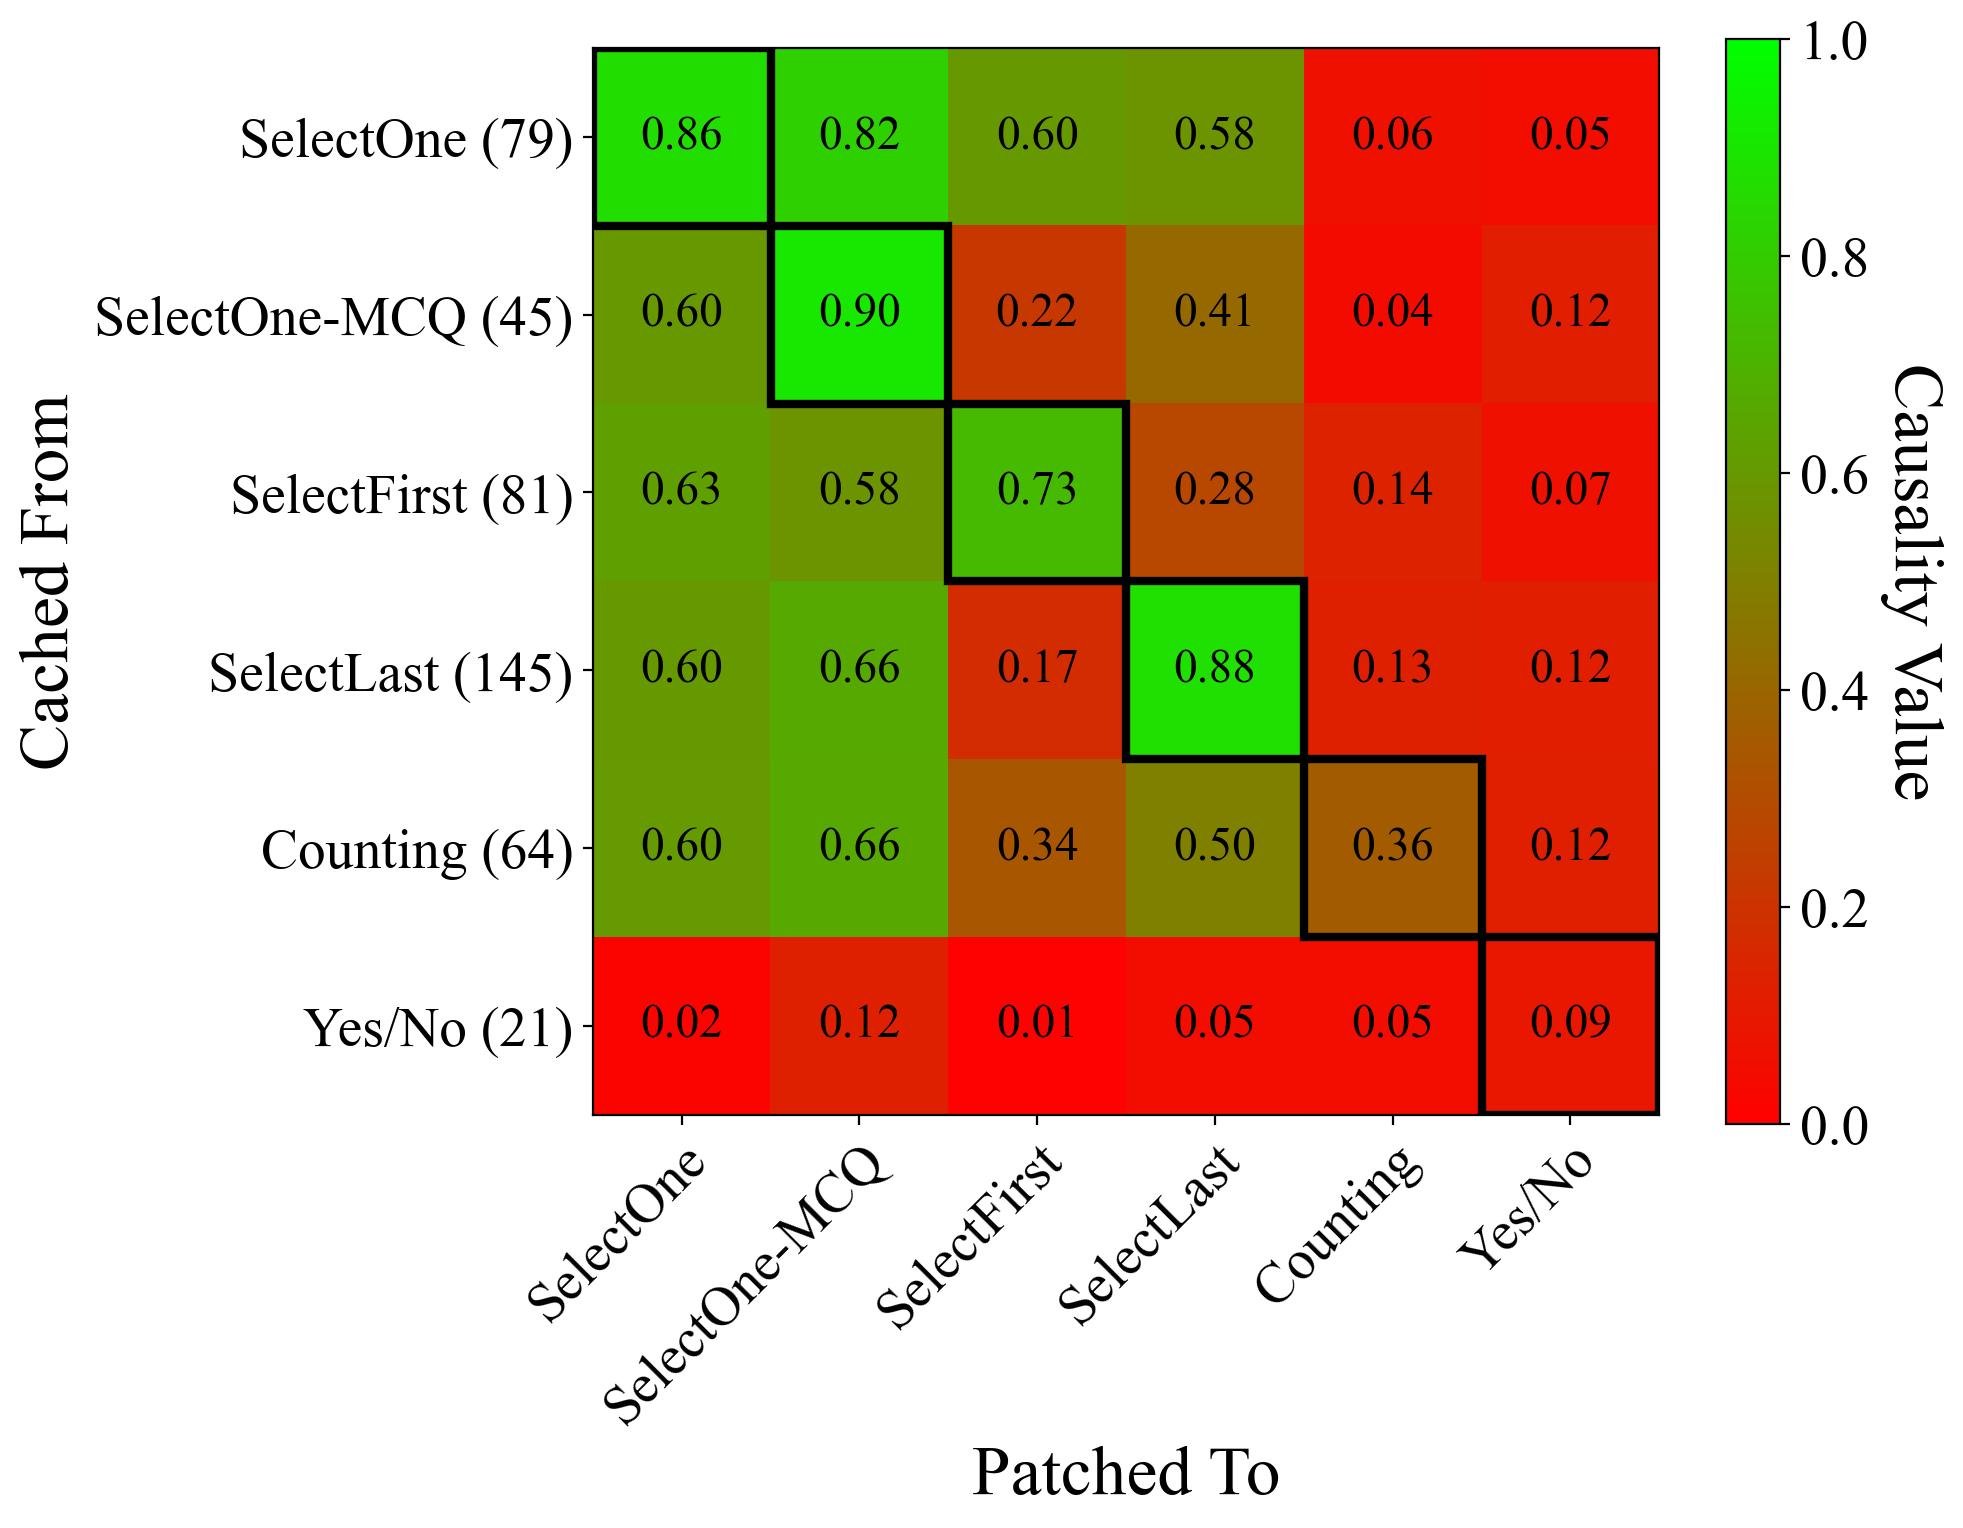

In [6]:
from matplotlib import pyplot as plt
import os
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Rectangle

plt.rcdefaults()
plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.family"] = "Times New Roman"

SMALL_SIZE = 17
MEDIUM_SIZE = 20
BIGGER_SIZE = 25

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=BIGGER_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title


# Extract labels for the axes
labels = [
    "Select One",
    "Select One - MCQ",
    "Select First",
    "Select Last",
    "Counting",
    "Yes/No"
]
num_labels = len(labels)

# Create a 2D numpy array to hold the causality values
causality_matrix = np.zeros((num_labels, num_labels))

for i, trained_on in enumerate(labels):
    eval_data = cached_from_and_patched_to[trained_on]["evaluation"]
    for j, evaluated_on in enumerate(labels):
        causality_matrix[i, j] = eval_data[evaluated_on]["causality"]

# Create the plot
fig, ax = plt.subplots(figsize=(10, 8))
colors = [(1, 0, 0), (0, 1, 0)] # Red -> Green
# colors = ["#ff0000", "#4D7300"]
custom_cmap = LinearSegmentedColormap.from_list('green_to_red_cmap', colors, N=256)
im = ax.imshow(causality_matrix, cmap=custom_cmap, vmin=0, vmax=1)

# Set ticks and labels
ax.set_xticks(np.arange(num_labels))
ax.set_yticks(np.arange(num_labels))
ax.set_xticklabels([label.replace(" ", "") for label in labels])
ax.set_yticklabels([f'{label.replace(" ", "")} ({train_vs_evaluation[label]["num_heads"]})' for label in labels])

# Rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations
for i in range(num_labels):
    for j in range(num_labels):
        # Use a contrasting color for the text
        # text_color = "w" if causality_matrix[i, j] < 0.5 else "k"
        text_color = 'k'
        text = ax.text(j, i, f"{causality_matrix[i, j]:.2f}",
                       ha="center", va="center", color=text_color)

# Add black borders around diagonal cells (where i == j)
for i in range(num_labels):
    rect = Rectangle((i - 0.5, i - 0.5), 1, 1, 
                     linewidth=3, edgecolor='black', facecolor='none')
    ax.add_patch(rect)

# Add a colorbar
cbar = fig.colorbar(im)
cbar.set_label("Causality Value", rotation=-90, va="bottom")


ax.set_xlabel("Patched To")
ax.set_ylabel("Cached From")
# ax.set_title("Causality Confusion Matrix")

# Adjust layout to prevent labels from being cut off
fig.tight_layout()

# Save the figure
save_path = os.path.join("figures")
os.makedirs(save_path, exist_ok=True)
plt.savefig(os.path.join(save_path, "pred_transfer.pdf"), bbox_inches="tight")

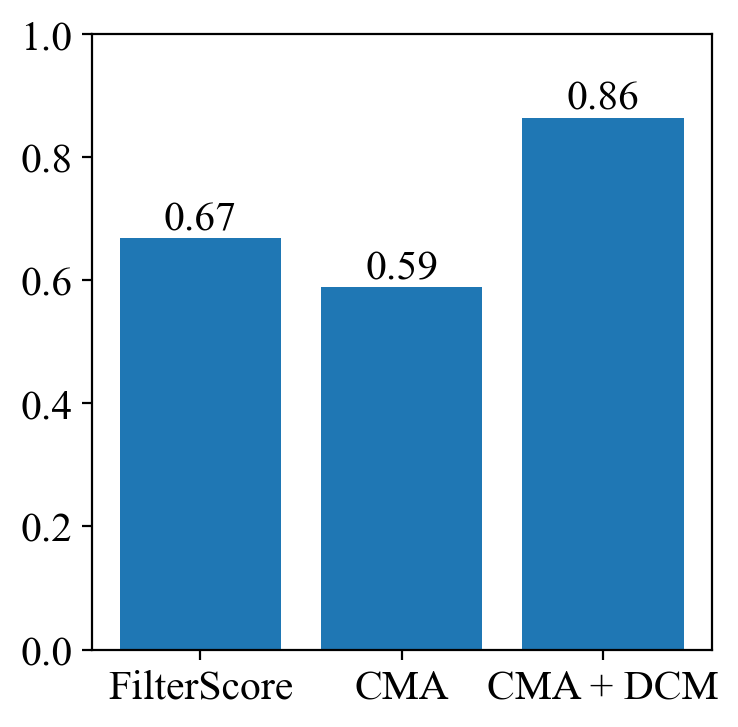

In [7]:
from matplotlib import pyplot as plt
import os

plt.rcdefaults()
plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.family"] = "Times New Roman"

SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 25

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=SMALL_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

scores = {
    "FilterScore": {
        "score": 0.6680,
        "n_correct": 342,
        "out_of": 512
    },
    "CMA": {
        "score": 0.5879,
        "n_correct": 301,
        "out_of": 512
    },
    "CMA + DCM": {
        "score": 0.8633,
        "n_correct": 884,
        "out_of": 1024
    }
}


plt.figure(figsize=(4, 4))
bars = plt.bar(scores.keys(), [v["score"] for v in scores.values()])
plt.ylim(0, 1)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f"{height:.2f}", ha='center', va='bottom')


# Save the figure
save_path = os.path.join("figures")
os.makedirs(save_path, exist_ok=True)
plt.savefig(os.path.join(save_path, "causality_diff_approach.pdf"), bbox_inches="tight")

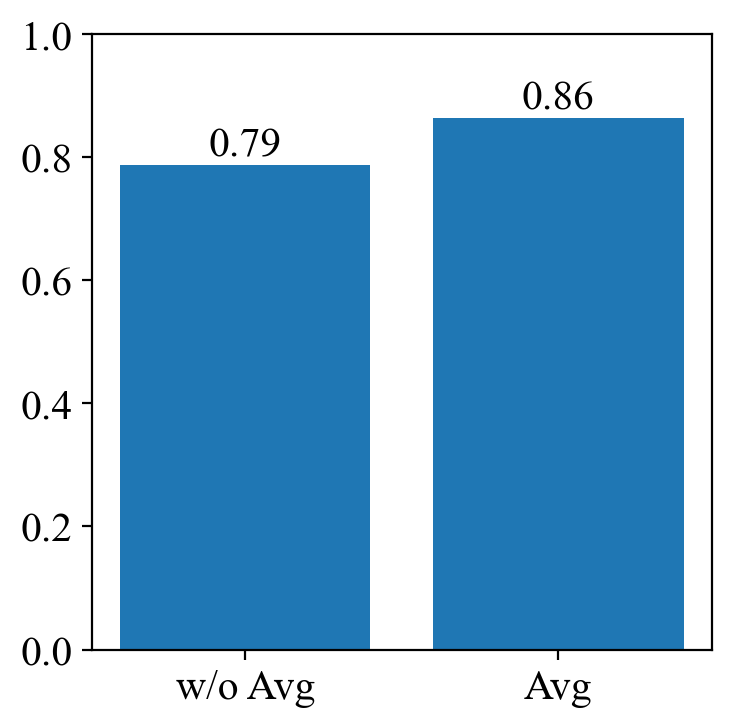

In [8]:
from matplotlib import pyplot as plt
import os

plt.rcdefaults()
plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.family"] = "Times New Roman"

SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 25

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=SMALL_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

scores = {
    "w/o Avg": {
        "score": 0.7871,
        "n_correct": 403,
        "out_of": 512
    },
    "Avg": {
        "score": 0.863,
        "n_correct": 442,
        "out_of": 512
    },
}


plt.figure(figsize=(4, 4))
bars = plt.bar(scores.keys(), [v["score"] for v in scores.values()])
plt.ylim(0, 1)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f"{height:.2f}", ha='center', va='bottom')


# Save the figure
save_path = os.path.join("figures")
os.makedirs(save_path, exist_ok=True)
plt.savefig(os.path.join(save_path, "avg_trick_scores.pdf"), bbox_inches="tight")

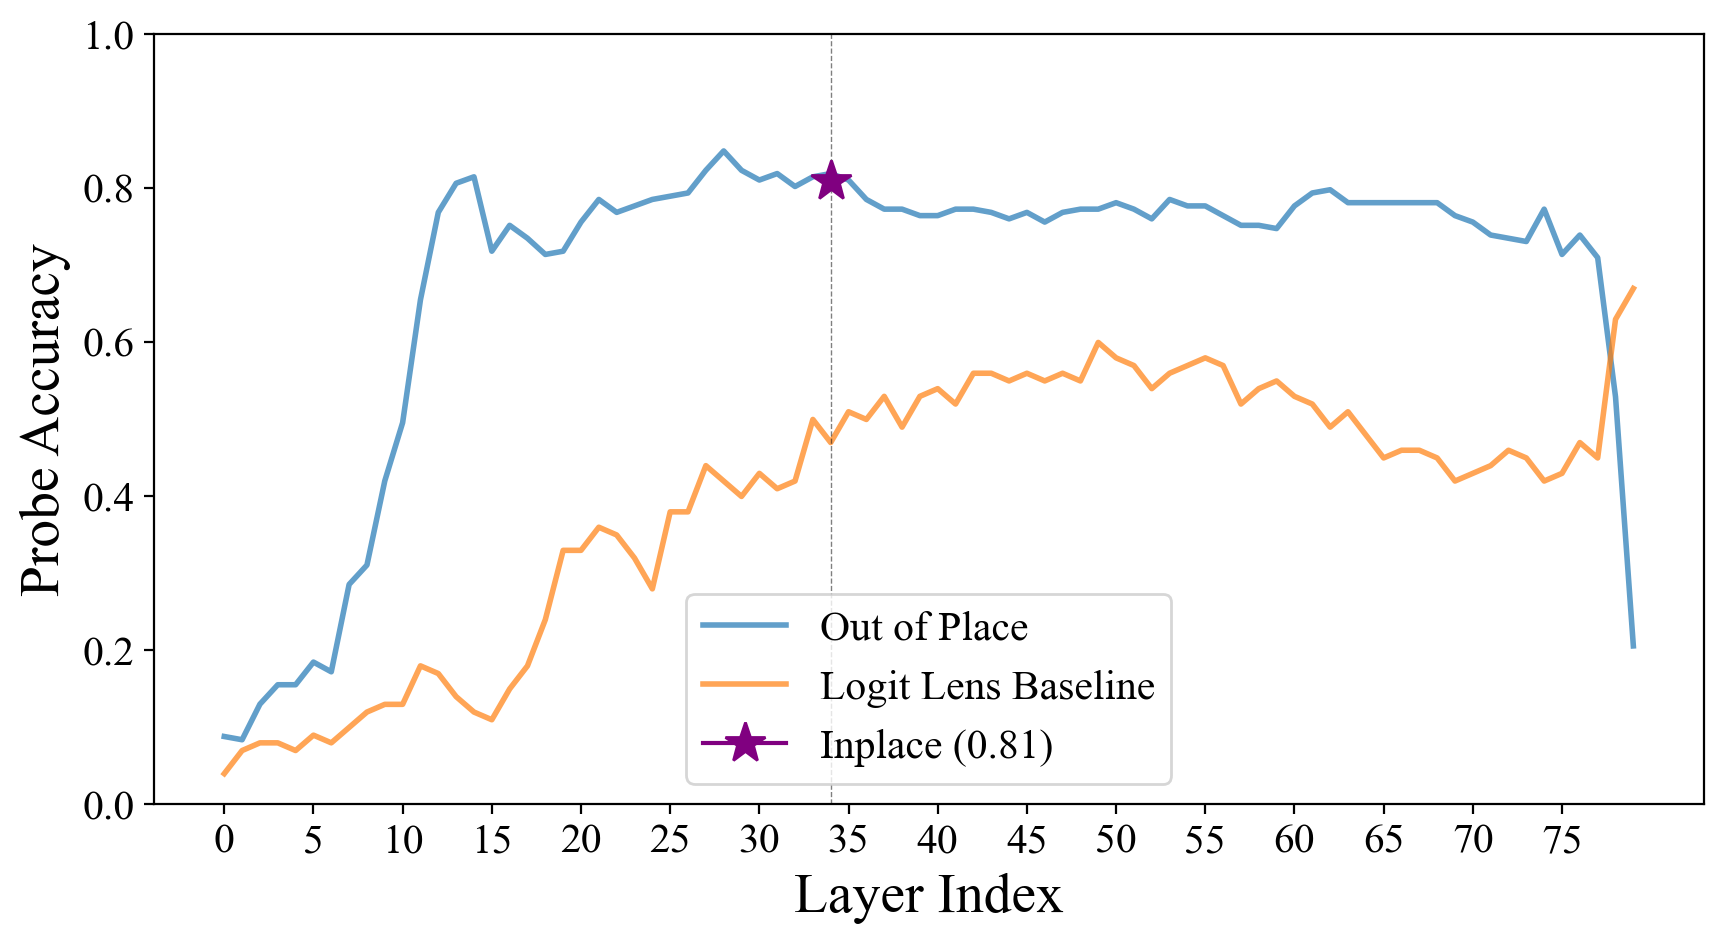

In [34]:
from matplotlib import pyplot as plt
import os

plt.rcdefaults()
plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.family"] = "Times New Roman"

SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 25

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

with open("figures/Llama-3.3-70B-Instruct/raw/probe_performance.json") as f:
    import json

    probe_performance = json.load(f)

probe_accuracy = probe_performance["out_of_place"]
logitlens_baseline = probe_performance["logit_lens_baseline"]

plt.figure(figsize=(10, 5))
plt.plot(
    list(probe_accuracy.keys()),
    list(probe_accuracy.values()),
    label="Out of Place",
    alpha=0.7,
    linewidth=2,
)
plt.plot(
    list(logitlens_baseline.keys()),
    list(logitlens_baseline.values()),
    label="Logit Lens Baseline",
    alpha=0.7,
    linewidth=2,
)
plt.vlines(34, 0, 78, colors='black', linestyles='dashed', linewidth=0.5, alpha=0.5)
plt.plot(
    [34], [0.81], marker="*", markersize=15, color="purple", label="Inplace (0.81)"
)
plt.xlabel("Layer Index")
plt.ylabel("Probe Accuracy")
plt.xticks(range(0, 79, 5))
plt.ylim(0, 1)
plt.legend()

plt.savefig(os.path.join("figures", "probe_performance.pdf"), bbox_inches="tight")